In [1]:
import torch
import torch.nn as nn
from torch import optim
from network import *
from distributions import *
from utils import *
import torch.distributions as dis
from torch.distributions.bernoulli import Bernoulli
import numpy as np
import torch.nn.functional as F
from utils import batch_KL_diag_gaussian_std
from custom_optimizer import SGLD
eps = 1e-7

In [36]:
class dense_VAE(nn.Module):
    def __init__(self, opt):
        super().__init__()
        self.device = opt['device']
        if opt['data_set'] == 'MNIST' or opt['data_set'] == 'BinaryMNIST':
            self.input_dim = 32 * 32
            self.output_dim = 10
            self.latent_dim = 100
        self.encoder = dense_encoder(self.input_dim, self.output_dim, self.latent_dim)
        if opt['x_dis'] == 'MixLogistic':
            self.decoder = dense_decoder(self.input_dim, self.output_dim, self.latent_dim)
            self.criterion = lambda real, fake: Bernoulli(logits=fake).log_prob(real).sum()
            self.sample_op = lambda x: Bernoulli(logits=x).sample()
        elif opt['x_dis'] == 'Logistic':
            self.decoder = dense_decoder(self.input_dim, self.output_dim, self.latent_dim)
            self.criterion = lambda real, fake: Bernoulli(logits=fake).log_prob(real).sum()
            self.sample_op = lambda x: Bernoulli(logits=x).sample()
        
        self.classifier = nn.Sequential(nn.Linear(self.latent_dim, 10), nn.Softmax()).to(self.device)
        self.prior_mu = torch.zeros(self.latent_dim, requires_grad=False)
        self.prior_std = torch.ones(self.latent_dim, requires_grad=False)
        self.params = list(self.parameters())

    def posterior_forward(self, params, x):
        z_mu, z_std = params[0], F.softplus(params[1])
        eps = torch.randn_like(z_mu).to(self.device)
        zs = eps.mul(z_std).add_(z_mu)
        pxz_params = self.decoder(zs)
        pxz_params = pxz_params.reshape([-1, 1, 32, 32])
        loglikelihood = self.criterion(x, pxz_params)
        kl = batch_KL_diag_gaussian_std(z_mu, z_std, self.prior_mu.to(self.device), self.prior_std.to(self.device))
        elbo = loglikelihood - kl
        return torch.mean(elbo) / np.log(2.)

    def forward(self, x):
        z_mu, z_std = self.encoder(x)
        eps = torch.randn_like(z_mu).to(self.device)
        zs = eps.mul(z_std).add_(z_mu)
        pxz_params = self.decoder(zs)
        loglikelihood = self.criterion(x, pxz_params)
        
        kl = batch_KL_diag_gaussian_std(z_mu, z_std, self.prior_mu.to(self.device), self.prior_std.to(self.device))
        elbo = loglikelihood - kl
        return torch.mean(elbo) / np.log(2.)
    
    def joint_forward(self, x, y, alpha=0.0, return_elbo=False):
        z_mu, z_std = self.encoder(x)
        eps = torch.randn_like(z_mu).to(self.device)
        z = eps.mul(z_std).add_(z_mu)
        x_out = self.decoder(z)
        kl = batch_KL_diag_gaussian_std(z_mu, z_std, self.prior_mu.to(self.device), self.prior_std.to(self.device))
        neg_l = - self.criterion(x, x_out)
        
        y_z_dis = self.classifier(z)
        if return_elbo:
            logpy_z = torch.sum(y * torch.log(y_z_dis + 1e-8), dim=1)
            return -neg_l + logpy_z - kl

        classification_loss = -torch.sum(y * torch.log(y_z_dis + 1e-8), dim=1).mean()
        loss = torch.mean(neg_l + kl, dim=0) + alpha * classification_loss
        return loss
    
    def sample(self, num=100):
        with torch.no_grad():
            eps = torch.randn(num, self.latent_dim).to(self.device)
            pxz_params = self.decoder(eps)
            samples = self.sample_op(pxz_params)
            return samples.reshape([-1, 1, 32, 32])
    
    def logpyz(self, z, y):
        y_z_dis = self.classifier(z.view(-1, self.latent_dim))
        logpy_z = torch.sum(y * torch.log(y_z_dis + 1e-8), dim=1)
        logp_z = dis.Normal(self.prior_mu.to(self.device), self.prior_std.to(self.device)).log_prob(z).sum(-1)
        return logpy_z + logp_z
    
    def conditional_sample(self, y, optimi):
        loss_list = []
        self.eval()
        y = F.one_hot(y, num_classes=10).to(self.device)
        z_opt = torch.randn(self.latent_dim, requires_grad=True)
        if optimi == 'sgld':
            optimizer = SGLD([z_opt], lr=0.01)
        elif optimi == 'adam':
            optimizer = optim.Adam([z_opt], lr=5e-2)
        sgld_samples = []
        z_opt = z_opt.to(self.device)
        for i in range(0, 100):
            optimizer.zero_grad()
            L = -self.logpyz(z_opt, y)
            L.backward()
            if optimi == 'sgld':
                sgld_sample = optimizer.step()
                sgld_samples.append(sgld_sample)
            elif optimi == 'adam':
                optimizer.step()
        
        with torch.no_grad():
            if optimi == 'sgld':
                final_samples = sgld_samples[50:]
                for k, z_sample in enumerate(final_samples):
                    vae_out = self.decoder(z_sample.view(1, -1).to(self.device))
                    if k == 0:
                        x_sample = self.sample_op(vae_out)
                    else:
                        x_sample += self.sample_op(vae_out)
                x_sample /= len(final_samples)
            elif optimi == 'adam':
                vae_out = self.decoder(z_opt.view(1, -1))
                x_sample = self.sample_op(vae_out)
            return x_sample



In [37]:
opt = {}
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    opt["device"] = torch.device("cuda:0")
    opt["if_cuda"] = True
else:
    opt["device"] = torch.device("cpu")
    opt["if_cuda"] = False

opt['data_set'] = 'BinaryMNIST'
opt['x_dis'] = 'Logistic'  ## or MixLogistic
opt['z_channels'] = 2  ## 2*64
opt['epochs'] = 100
opt['dataset_path'] = '../data/'
opt['save_path'] = './save/'
opt['result_path'] = './result/'
opt['batch_size'] = 100
opt['test_batch_size'] = 200
opt['if_regularizer'] = False
opt['load_model'] = False
opt['lr'] = 1e-3
opt['data_aug'] = False
opt["seed"] = 0
opt['if_save_model'] = True
opt['save_epoch'] = 50
opt['additional_epochs'] = 100
opt['sample_size'] = 100
opt['if_save_latent'] = True

np.random.seed(opt['seed'])
torch.manual_seed(opt['seed'])

train_data, test_data, train_data_evaluation = LoadData(opt)
model = dense_VAE(opt).to(opt['device'])

In [38]:
model.load_state_dict(torch.load('/home/ma-user/work/VAE_baseline/save/model_mnist.pth'))

<All keys matched successfully>

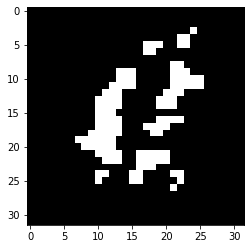

In [39]:
sample = model.conditional_sample(torch.tensor([7]), optimi='adam')

plt.figure()
plt.imshow(sample.cpu().numpy().reshape([32, 32, 1]), cmap='gray')
plt.show()

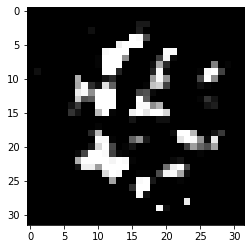

In [45]:
sample = model.conditional_sample(torch.tensor([0]), optimi='sgld')

plt.figure()
plt.imshow(sample.cpu().numpy().reshape([32, 32, 1]), cmap='gray')
plt.show()